In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from tqdm import tqdm
import os
from matplotlib import pyplot as plt 
import cv2
import numpy as np
import scipy.ndimage
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T
import torch.nn.functional as F

In [2]:
class CSRNet(nn.Module):
    def __init__(self, load_pretrained=True):
        super(CSRNet, self).__init__()

        vgg = models.vgg16(pretrained=load_pretrained)
        self.frontend = nn.Sequential(*list(vgg.features.children())[:23])  # Up to conv4_3

        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
        )

        self.output_layer = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        return x


In [3]:
class CrowdDataset(Dataset):
    def __init__(self, image_folder, density_map_folder, image_files, transform=None):
        self.image_folder = image_folder
        self.density_map_folder = density_map_folder
        self.image_files = image_files # Ensure sorted list
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        img_path = self.image_files[idx]
        # print(img_path)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image)
        else:
            image = image.astype(np.float32) / 255.0
            image = torch.from_numpy(image).permute(2, 0, 1)

        # Load and convert density map
        density_map_name = img_path.replace('.jpg', '_density.npy').replace(self.image_folder, self.density_map_folder)
        density_map = np.load(density_map_name)
        density_map = torch.from_numpy(density_map).unsqueeze(0).float()

        return image, density_map


In [4]:
train_resized_folder = "Train_resized_2"
train_density_folder = "Train_density_2"

train_image_paths = []
train_heatmap_paths = []

# Iterate over files in Train_resized folder
for file_name in os.listdir(train_resized_folder):
    if file_name.endswith(".jpg"):
        train_image_paths.append(os.path.join(train_resized_folder, file_name))

# Iterate over files in Train_density folder
for file_name in os.listdir(train_density_folder):
    if file_name.endswith(".npy"):
        train_heatmap_paths.append(os.path.join(train_density_folder, file_name))

print(f"Found {len(train_image_paths)} images and {len(train_heatmap_paths)} heatmaps.")


validation_resized_folder = "Validation_resized_2"
validation_density_folder = "Validation_density_2"
validation_image_paths = []
validation_heatmap_paths = []

# Iterate over files in Validation_resized folder
for file_name in os.listdir(validation_resized_folder):
    if file_name.endswith(".jpg"):
        validation_image_paths.append(os.path.join(validation_resized_folder, file_name))

# Iterate over files in Validation_density folder
for file_name in os.listdir(validation_density_folder):
    if file_name.endswith(".npy"):
        validation_heatmap_paths.append(os.path.join(validation_density_folder, file_name))

print(f"Found {len(validation_image_paths)} images and {len(validation_heatmap_paths)} heatmaps.")

Found 4804 images and 4804 heatmaps.
Found 668 images and 668 heatmaps.


In [5]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [6]:
train_dataset = CrowdDataset(train_resized_folder, train_density_folder, train_image_paths, transform)
validation_dataset = CrowdDataset(validation_resized_folder, validation_density_folder, validation_image_paths, transform)

In [7]:
# Hyperparameter code block: modify this to test your models!
train_loader_batch_size = 10
validation_loader_batch_size = 10
epochs = 3
model_lr = 1e-3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CSRNet().to(device)
print(device)
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
train_loader = DataLoader(train_dataset, batch_size=train_loader_batch_size, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=validation_loader_batch_size, shuffle=False)

C:\Users\ryan_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ryan_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cpu


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


8710


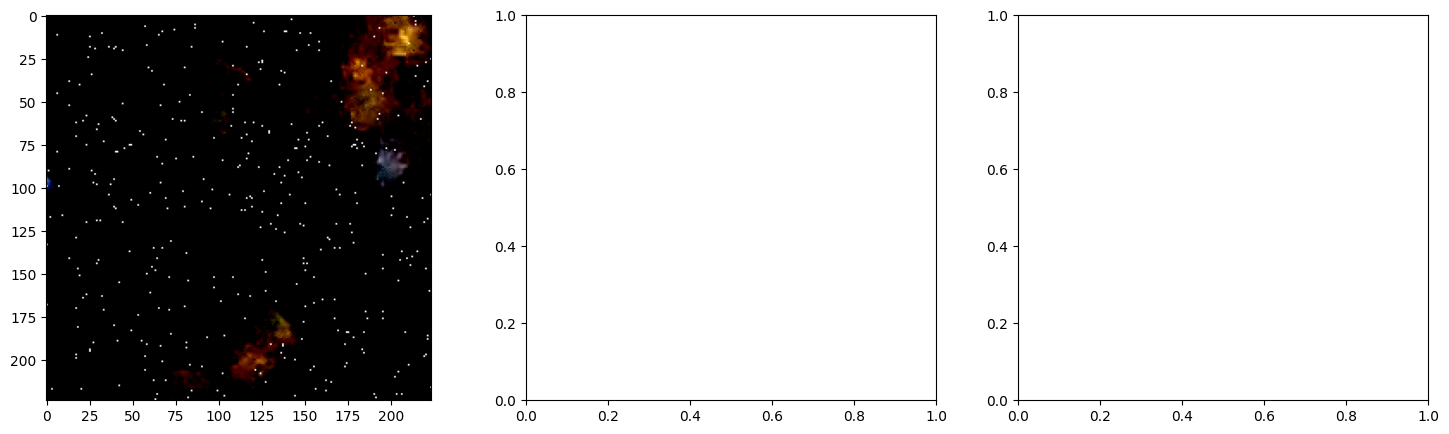

In [16]:
train_resized_folder_images = os.listdir(train_resized_folder)
print(train_resized_folder_images.index('img_1089_crop_3.jpg'))
image, gt_density = train_loader.dataset[int(8710/2)]
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Original image
axs[0].imshow(image.squeeze().permute(1, 2, 0).cpu().numpy())